### Week 2 (W37) – 11.09 – 17.09 - Understand your data and your modelling goal
- an established communication channel and appropriate strategy for code sharing.
- data correctly imported into appropriate matrices completely: observations as rows, variables (predictors) as columns.
- identification of challenges of the data: for example: time series not synchronized, missing values in data, extra variables, variables with unknown physical meanings, etc.
- a visualization and comment on the dataset: variable distribution, number of observations, type of measurements (time series or not time series)
- identification of pretreatment steps, and a plan on how to do data pretreatment

### -Importing necessary libraries

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

### - Load the dataset and preprocess

In [2]:
# Load the dataset and preprocess
df = pd.read_csv("../dataset/MiningProcess_Flotation_Plant_Database.csv")


### - Displaying first few rows/observations of the dataset

In [3]:
# Displaying first few rows/observations of the dataset
df.head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,"55,2","16,98","3019,53","557,434","395,713","10,0664","1,74","249,214","253,235",...,"250,884","457,396","432,962","424,954","443,558","502,255","446,37","523,344","66,91","1,31"
1,2017-03-10 01:00:00,"55,2","16,98","3024,41","563,965","397,383","10,0672","1,74","249,719","250,532",...,"248,994","451,891","429,56","432,939","448,086","496,363","445,922","498,075","66,91","1,31"
2,2017-03-10 01:00:00,"55,2","16,98","3043,46","568,054","399,668","10,068","1,74","249,741","247,874",...,"248,071","451,24","468,927","434,61","449,688","484,411","447,826","458,567","66,91","1,31"
3,2017-03-10 01:00:00,"55,2","16,98","3047,36","568,665","397,939","10,0689","1,74","249,917","254,487",...,"251,147","452,441","458,165","442,865","446,21","471,411","437,69","427,669","66,91","1,31"
4,2017-03-10 01:00:00,"55,2","16,98","3033,69","558,167","400,254","10,0697","1,74","250,203","252,136",...,"248,928","452,441","452,9","450,523","453,67","462,598","443,682","425,679","66,91","1,31"


### - Number of Rows and columns

In [4]:
# Rows and columns
df.shape

(737453, 24)

### - Print all the column names

In [5]:
# Print all the column names
df.columns.to_list()

['date',
 '% Iron Feed',
 '% Silica Feed',
 'Starch Flow',
 'Amina Flow',
 'Ore Pulp Flow',
 'Ore Pulp pH',
 'Ore Pulp Density',
 'Flotation Column 01 Air Flow',
 'Flotation Column 02 Air Flow',
 'Flotation Column 03 Air Flow',
 'Flotation Column 04 Air Flow',
 'Flotation Column 05 Air Flow',
 'Flotation Column 06 Air Flow',
 'Flotation Column 07 Air Flow',
 'Flotation Column 01 Level',
 'Flotation Column 02 Level',
 'Flotation Column 03 Level',
 'Flotation Column 04 Level',
 'Flotation Column 05 Level',
 'Flotation Column 06 Level',
 'Flotation Column 07 Level',
 '% Iron Concentrate',
 '% Silica Concentrate']

### - Convert the date column to CORRECT date-times
- This will help for further processing of data
- Need to convert/process 'date' column to make/form a time series

In [6]:
# Checking the number of entries for each hour
count_df = df.groupby(['date']).count()

In [7]:
count_df.reset_index(drop=True)

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,174,174,174,174,174,174,174,174,174,174,...,174,174,174,174,174,174,174,174,174,174
1,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180
2,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180
3,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180
4,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4092,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180
4093,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180
4094,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180
4095,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180


In [8]:
# Find most frequent count (or samples collected) per hour
unique_counts = count_df["Starch Flow"].value_counts()

In [9]:
unique_counts

180    4095
174       1
179       1
Name: Starch Flow, dtype: int64

In [10]:
high_freq = unique_counts.idxmax()

In [11]:
high_freq

180

In [12]:
wrong_num_sample_ids = count_df.index[count_df["Starch Flow"] != high_freq]
# wrong_num_sample_ids

# Convert the date column to datetime
df['date'] = pd.to_datetime(df['date'])
# The real start of recording is from 00:03:00
DATA_COLLECT_START = df["date"][0].replace(minute=3)

# Fix the missing entry on 10 May 2017
row_to_repeat = df.loc[df["date"] == wrong_num_sample_ids[1]].iloc[0]
df.loc[-1] = row_to_repeat
df = df.sort_index()

# get gaps in time
t = pd.Timedelta('1hour')
mask = df['date'].diff().gt(t)
starts = df.loc[mask.shift(-1, fill_value=False), 'date'].add(t).astype(str)
stops = df.loc[mask, 'date'].sub(t).astype(str)
out = list(zip(starts, stops))

# Get list of start-end periods fo data collection
starts_ends = [str(DATA_COLLECT_START),
       str(datetime.datetime.strptime(out[0][0], '%Y-%m-%d %H:%M:%S')
           - datetime.timedelta(hours=1)),
       str(datetime.datetime.strptime(out[0][1], '%Y-%m-%d %H:%M:%S')
           - datetime.timedelta(seconds=20)),
       str(df["date"][df["date"].idxmax()] + datetime.timedelta(hours=1))]

# Get correct datetimes for dataset based on sampling rate
dates = pd.date_range(start=starts_ends[0], end=starts_ends[1], freq='20S')
dates = dates.union(pd.date_range(start=starts_ends[2], end=starts_ends[3], freq='20S'))
dates

DatetimeIndex(['2017-03-10 01:03:00', '2017-03-10 01:03:20',
               '2017-03-10 01:03:40', '2017-03-10 01:04:00',
               '2017-03-10 01:04:20', '2017-03-10 01:04:40',
               '2017-03-10 01:05:00', '2017-03-10 01:05:20',
               '2017-03-10 01:05:40', '2017-03-10 01:06:00',
               ...
               '2017-09-09 23:57:00', '2017-09-09 23:57:20',
               '2017-09-09 23:57:40', '2017-09-09 23:58:00',
               '2017-09-09 23:58:20', '2017-09-09 23:58:40',
               '2017-09-09 23:59:00', '2017-09-09 23:59:20',
               '2017-09-09 23:59:40', '2017-09-10 00:00:00'],
              dtype='datetime64[ns]', length=737454, freq=None)

### - Replace date column with correct date-times and set variable as index

In [13]:
df["date"] = dates
df.set_index('date', inplace=True)

# Check convertion
df.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:03:00,"56,39","13,53","2082,27","391,733","403,738","9,70067","1,74925","250,509","251,163","250,61",...,"249,43","606,023","596,422","604,776","437,7","430,352","433,92","443,036","65,85","1,4"
2017-03-10 01:03:20,"55,2","16,98","3019,53","557,434","395,713","10,0664","1,74","249,214","253,235","250,576",...,"250,884","457,396","432,962","424,954","443,558","502,255","446,37","523,344","66,91","1,31"
2017-03-10 01:03:40,"55,2","16,98","3024,41","563,965","397,383","10,0672","1,74","249,719","250,532","250,862",...,"248,994","451,891","429,56","432,939","448,086","496,363","445,922","498,075","66,91","1,31"
2017-03-10 01:04:00,"55,2","16,98","3043,46","568,054","399,668","10,068","1,74","249,741","247,874","250,313",...,"248,071","451,24","468,927","434,61","449,688","484,411","447,826","458,567","66,91","1,31"
2017-03-10 01:04:20,"55,2","16,98","3047,36","568,665","397,939","10,0689","1,74","249,917","254,487","250,049",...,"251,147","452,441","458,165","442,865","446,21","471,411","437,69","427,669","66,91","1,31"


### - Convert columns/variables to numeric

In [14]:
# Convert columns/variables to numeric
# Replace ',' by '.'
for col in df.columns:
    df[col] = df[col].str.replace(',', '.').astype(float)

In [15]:
# Check convertion
df.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:03:00,56.39,13.53,2082.27,391.733,403.738,9.70067,1.74925,250.509,251.163,250.610,...,249.430,606.023,596.422,604.776,437.700,430.352,433.920,443.036,65.85,1.40
2017-03-10 01:03:20,55.20,16.98,3019.53,557.434,395.713,10.06640,1.74000,249.214,253.235,250.576,...,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
2017-03-10 01:03:40,55.20,16.98,3024.41,563.965,397.383,10.06720,1.74000,249.719,250.532,250.862,...,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2017-03-10 01:04:00,55.20,16.98,3043.46,568.054,399.668,10.06800,1.74000,249.741,247.874,250.313,...,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
2017-03-10 01:04:20,55.20,16.98,3047.36,568.665,397.939,10.06890,1.74000,249.917,254.487,250.049,...,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31


### - Checking datatypes of all columns

In [16]:
# Checking datatypes of all columns
df.dtypes

% Iron Feed                     float64
% Silica Feed                   float64
Starch Flow                     float64
Amina Flow                      float64
Ore Pulp Flow                   float64
Ore Pulp pH                     float64
Ore Pulp Density                float64
Flotation Column 01 Air Flow    float64
Flotation Column 02 Air Flow    float64
Flotation Column 03 Air Flow    float64
Flotation Column 04 Air Flow    float64
Flotation Column 05 Air Flow    float64
Flotation Column 06 Air Flow    float64
Flotation Column 07 Air Flow    float64
Flotation Column 01 Level       float64
Flotation Column 02 Level       float64
Flotation Column 03 Level       float64
Flotation Column 04 Level       float64
Flotation Column 05 Level       float64
Flotation Column 06 Level       float64
Flotation Column 07 Level       float64
% Iron Concentrate              float64
% Silica Concentrate            float64
dtype: object

### - Missing/null value checking

In [17]:
# Missing/null value checking
# All variables converted to numeric
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 737454 entries, 2017-03-10 01:03:00 to 2017-09-10 00:00:00
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   % Iron Feed                   737454 non-null  float64
 1   % Silica Feed                 737454 non-null  float64
 2   Starch Flow                   737454 non-null  float64
 3   Amina Flow                    737454 non-null  float64
 4   Ore Pulp Flow                 737454 non-null  float64
 5   Ore Pulp pH                   737454 non-null  float64
 6   Ore Pulp Density              737454 non-null  float64
 7   Flotation Column 01 Air Flow  737454 non-null  float64
 8   Flotation Column 02 Air Flow  737454 non-null  float64
 9   Flotation Column 03 Air Flow  737454 non-null  float64
 10  Flotation Column 04 Air Flow  737454 non-null  float64
 11  Flotation Column 05 Air Flow  737454 non-null  float64
 12  Flotation 

### - Cross-checking if there is any null values

In [18]:
# Cross-checking if there is any null values
df.isnull().sum()

% Iron Feed                     0
% Silica Feed                   0
Starch Flow                     0
Amina Flow                      0
Ore Pulp Flow                   0
Ore Pulp pH                     0
Ore Pulp Density                0
Flotation Column 01 Air Flow    0
Flotation Column 02 Air Flow    0
Flotation Column 03 Air Flow    0
Flotation Column 04 Air Flow    0
Flotation Column 05 Air Flow    0
Flotation Column 06 Air Flow    0
Flotation Column 07 Air Flow    0
Flotation Column 01 Level       0
Flotation Column 02 Level       0
Flotation Column 03 Level       0
Flotation Column 04 Level       0
Flotation Column 05 Level       0
Flotation Column 06 Level       0
Flotation Column 07 Level       0
% Iron Concentrate              0
% Silica Concentrate            0
dtype: int64

### - Checking additional statistics- (e.g. count, mean, std, 25%, 50%,75%, min, max)

In [19]:
# Checking additional statistics- (e.g. count, mean, std, 25%, 50%,75%, min, max)
df.describe()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
count,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000,...,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000
mean,56.294739,14.651714,2869.139502,488.144566,397.578380,9.767639,1.680380,280.151816,277.159930,281.082356,...,290.754800,520.244939,522.649655,531.352762,420.320997,425.251713,429.941023,421.021260,65.050069,2.326762
std,5.157741,6.807434,1215.203256,91.230541,9.699781,0.387007,0.069249,29.621288,30.149351,28.558271,...,28.670126,131.014873,128.164992,150.842086,91.794372,84.535765,89.862164,84.891437,1.118644,1.125553
min,42.740000,1.310000,0.002026,241.669000,376.249000,8.753340,1.519820,175.510000,175.156000,176.469000,...,185.962000,149.218000,210.752000,126.255000,162.201000,166.991000,155.841000,175.349000,62.050000,0.600000
25%,52.670000,8.940000,2076.320000,431.795250,394.264000,9.527360,1.647310,250.281000,250.457000,250.855000,...,256.301250,416.978000,441.883250,411.325250,356.679250,357.653250,358.497000,356.772000,64.370000,1.440000
50%,56.080000,13.850000,3018.430000,504.392789,399.249000,9.798100,1.697600,299.344000,296.223000,298.696000,...,299.011000,491.878000,495.956000,494.318000,411.974500,408.773500,424.664787,411.065500,65.210000,2.000000
75%,59.720000,19.600000,3727.730000,553.256750,402.968000,10.038000,1.728330,300.149000,300.690000,300.382000,...,301.904000,594.114000,595.464000,601.249000,485.549000,484.329000,492.684000,476.465000,65.860000,3.010000
max,65.780000,33.400000,6300.230000,739.538000,418.641000,10.808100,1.853250,373.871000,375.992000,364.346000,...,371.593000,862.274000,828.919000,886.822000,680.359000,675.644000,698.861000,659.902000,68.010000,5.530000


#### - Visualization (Box-Plot of all variables)

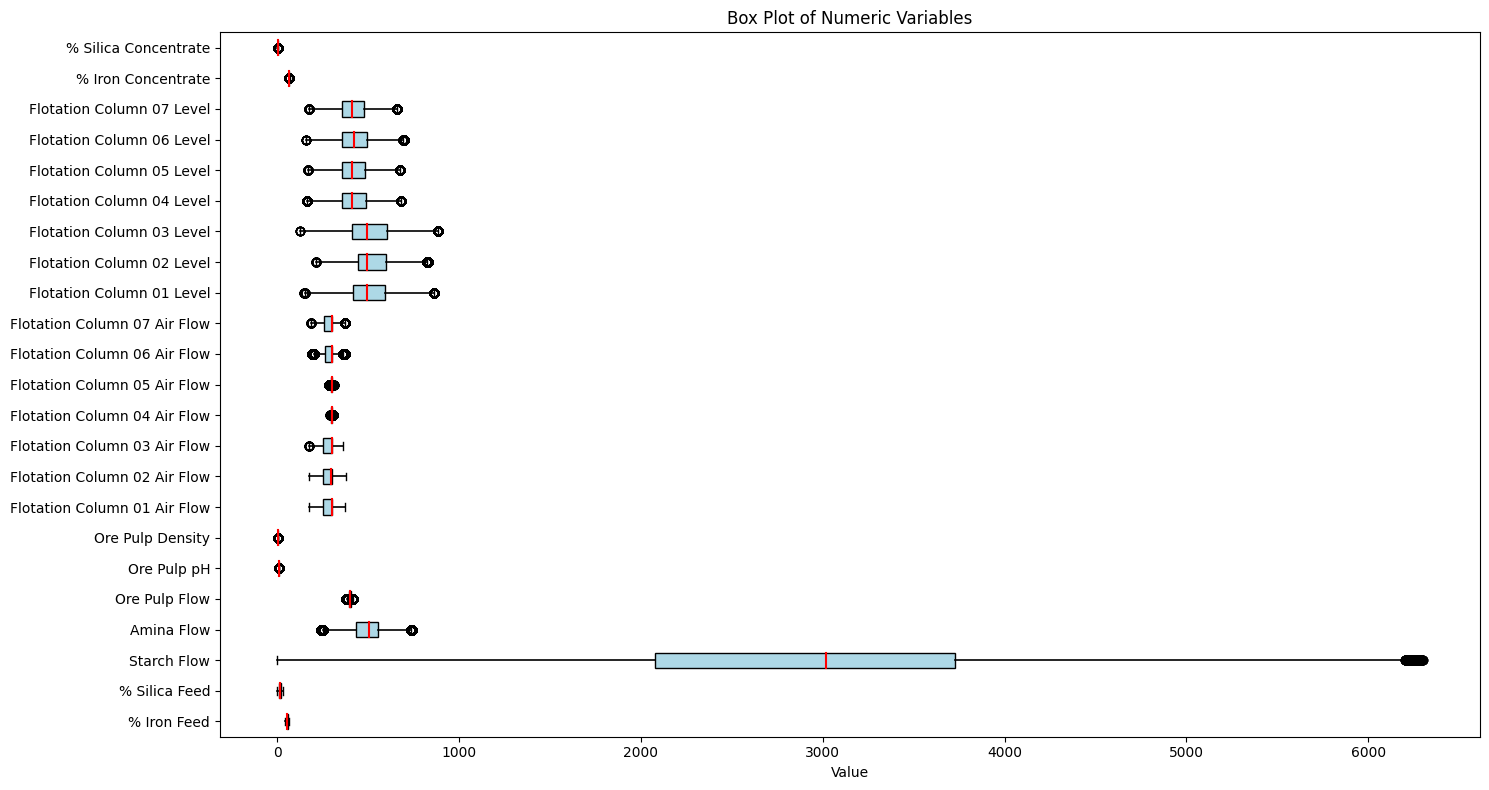

In [20]:
# Select numeric variables
numeric_variables = df.select_dtypes(include='number')

fig, ax = plt.subplots(figsize=(15, 8))

# Create a box plot for each numeric variable
box_plot = ax.boxplot(numeric_variables.values, vert=False, patch_artist=True)

for box in box_plot['boxes']:
    box.set(facecolor='lightblue')
for whisker in box_plot['whiskers']:
    whisker.set(color='black', linestyle='-', linewidth=1.2)
for median in box_plot['medians']:
    median.set(color='red', linewidth=1.5)

ax.set_yticklabels(numeric_variables.columns)

ax.set_xlabel('Value')
ax.set_title('Box Plot of Numeric Variables')

# Show the plot
plt.tight_layout()
plt.show()

#### - Visualization (individual Box-Plot of all variables)

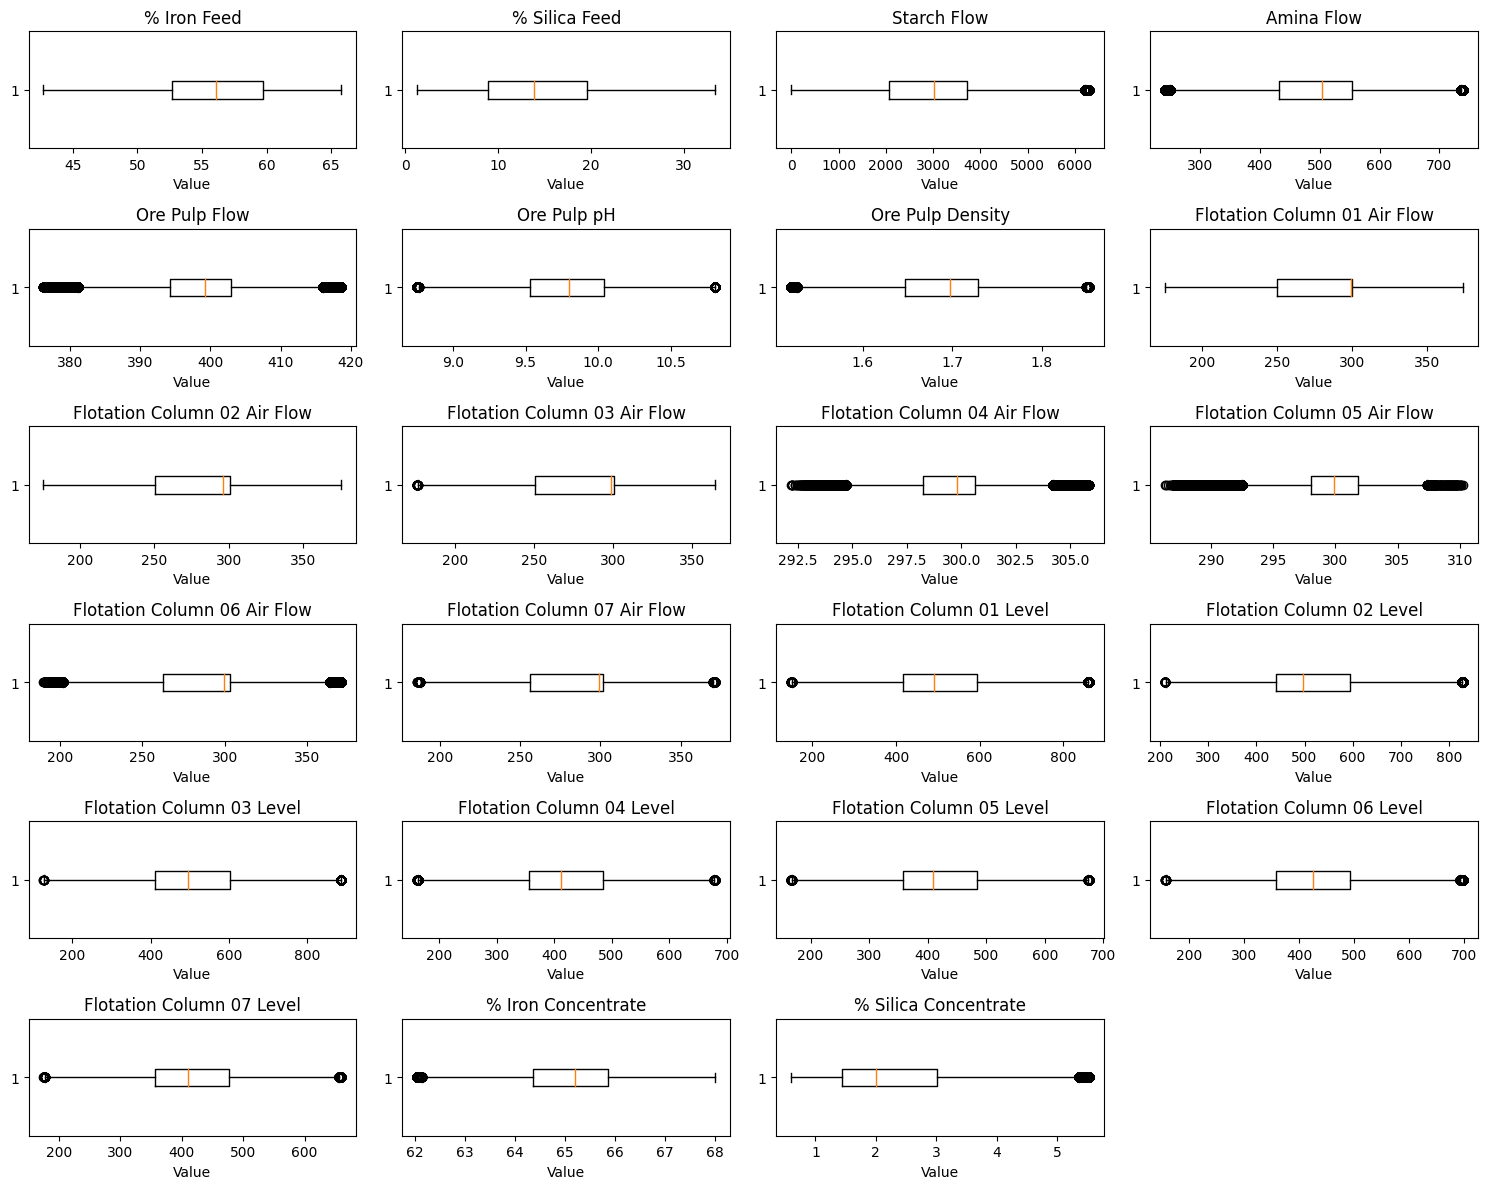

In [21]:
numeric_variables = df.select_dtypes(include='number')

column_names = numeric_variables.columns

# Subplots per row for better visualization
num_cols = 4
num_rows = len(column_names) // num_cols + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

if num_rows == 1:
    axes = axes.reshape(1, -1)

# Create box plots for each numeric variable
for i, column in enumerate(column_names):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]

    ax.boxplot(df[column], vert=False)
    ax.set_title(column)
    ax.set_xlabel('Value')

for i in range(len(column_names), num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

#### - Visualization (Histogram of all variables)

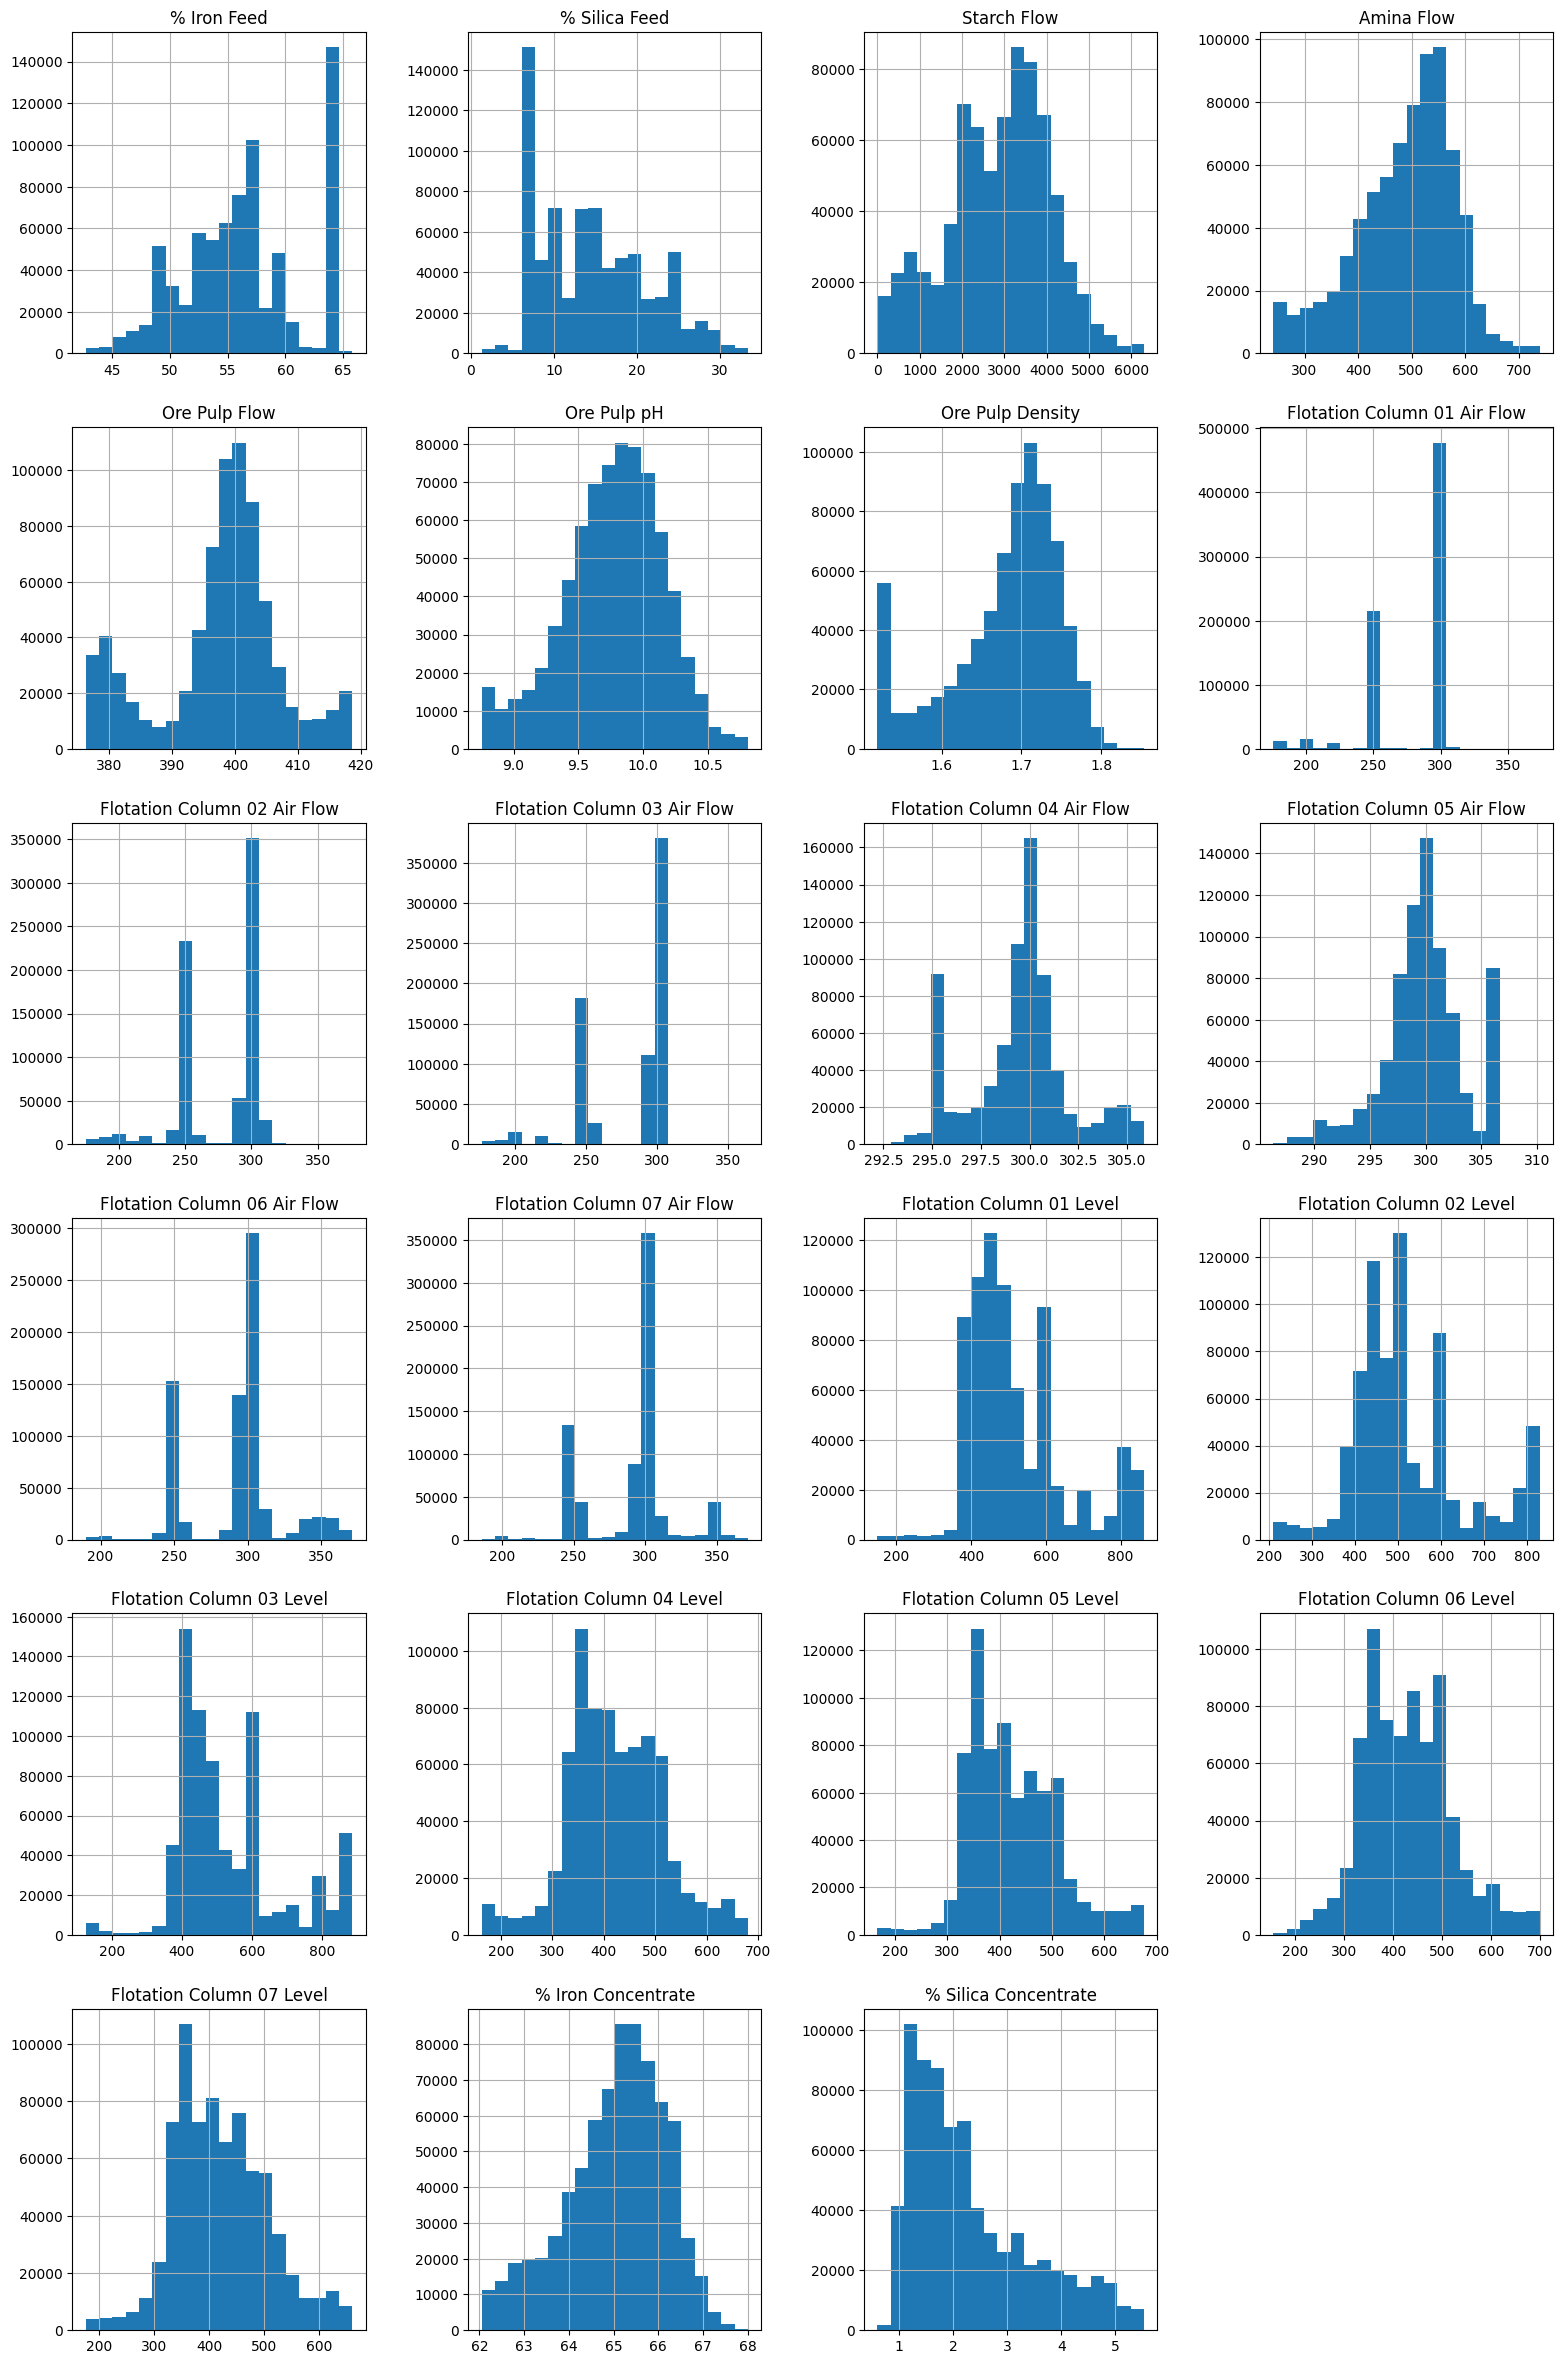

In [22]:
# Get numeric variables
numeric_variables = df.select_dtypes(include='number')

# Subplots per row for better visualization
subplots_per_row = 4
num_variables = len(numeric_variables.columns)
num_rows = (num_variables + subplots_per_row - 1) // subplots_per_row

fig, axes = plt.subplots(nrows=num_rows, ncols=subplots_per_row, figsize=(16, 4 * num_rows), sharex=False)

axes = axes.flatten()

# Plot histograms for each numeric variable
for i, col in enumerate(numeric_variables.columns):
    ax = axes[i]
    ax.hist(df[col], bins=20)
    ax.set_title(col)
    ax.grid(True)

for i in range(num_variables, num_rows * subplots_per_row):
    fig.delaxes(axes[i])

plt.tight_layout(pad=2.0)
plt.show()

### - Visualization (Correlation matrix)
- Find the relationships among variables, specially when there are huge number of observations
-  Helpful for understanding redundant variables

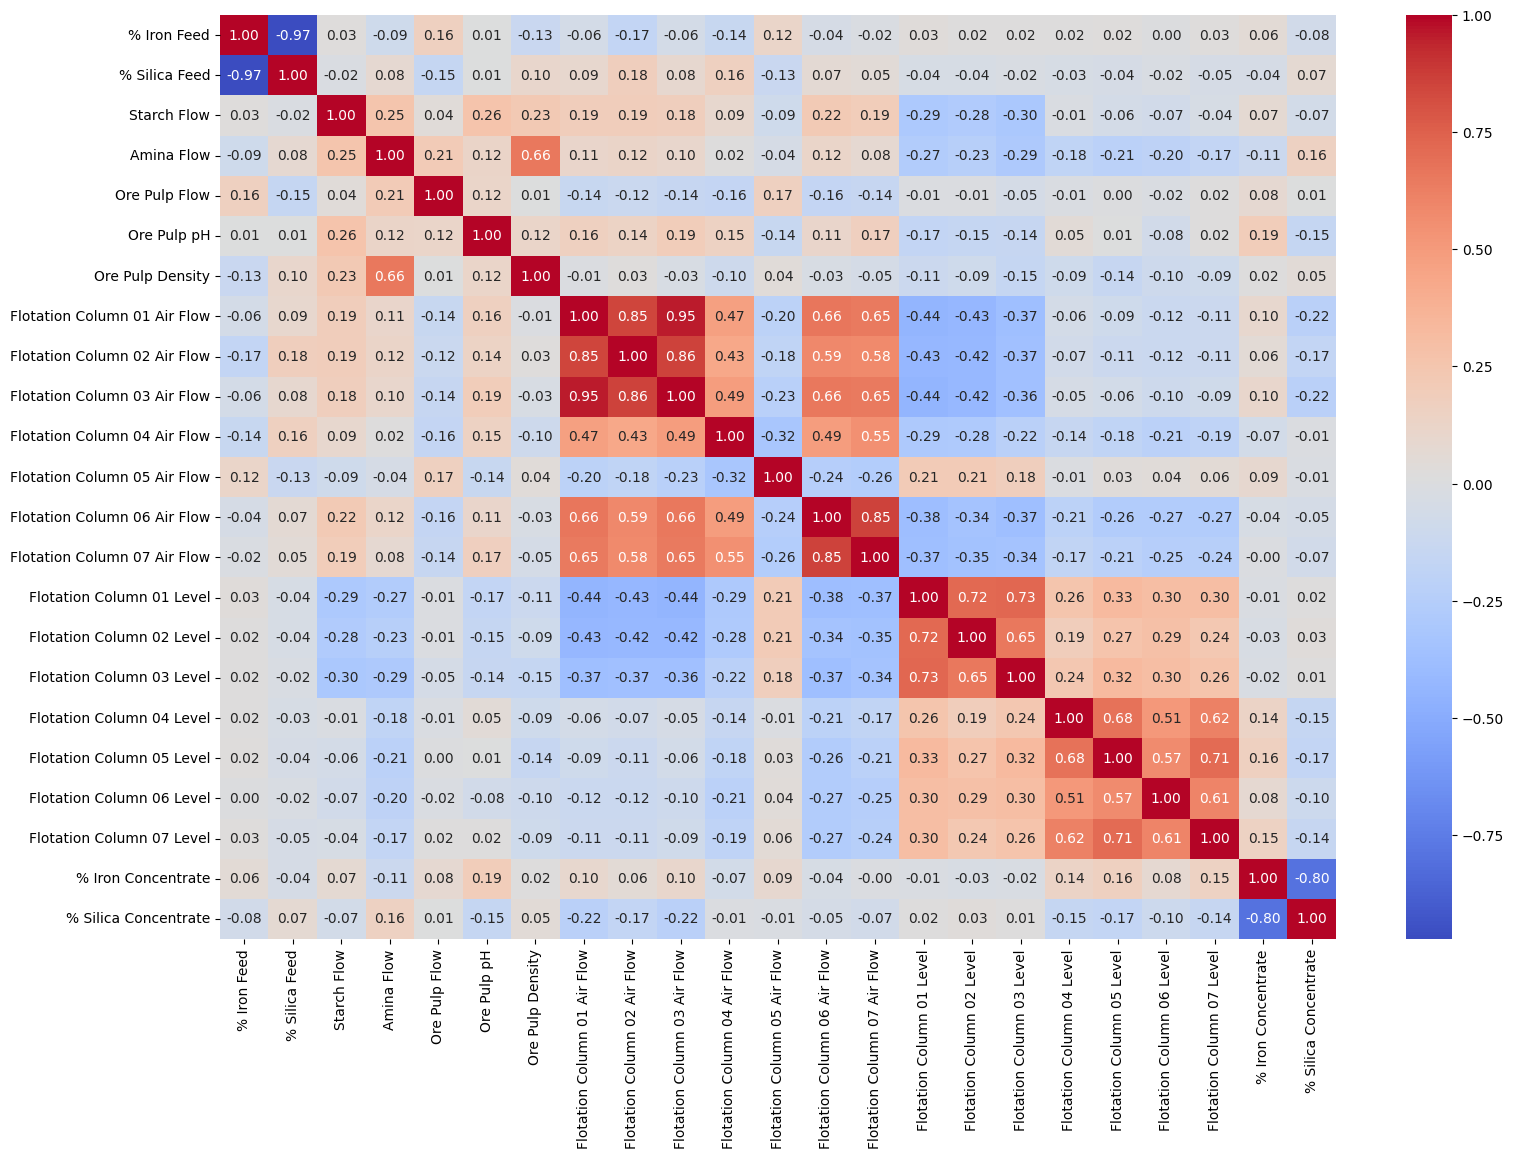

In [23]:
# Select numeric variables (excluding any non-numeric columns)
#numeric_variables = df.select_dtypes(include='number')

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

### - Plot against time
- Plot the time series for all variables in one figure

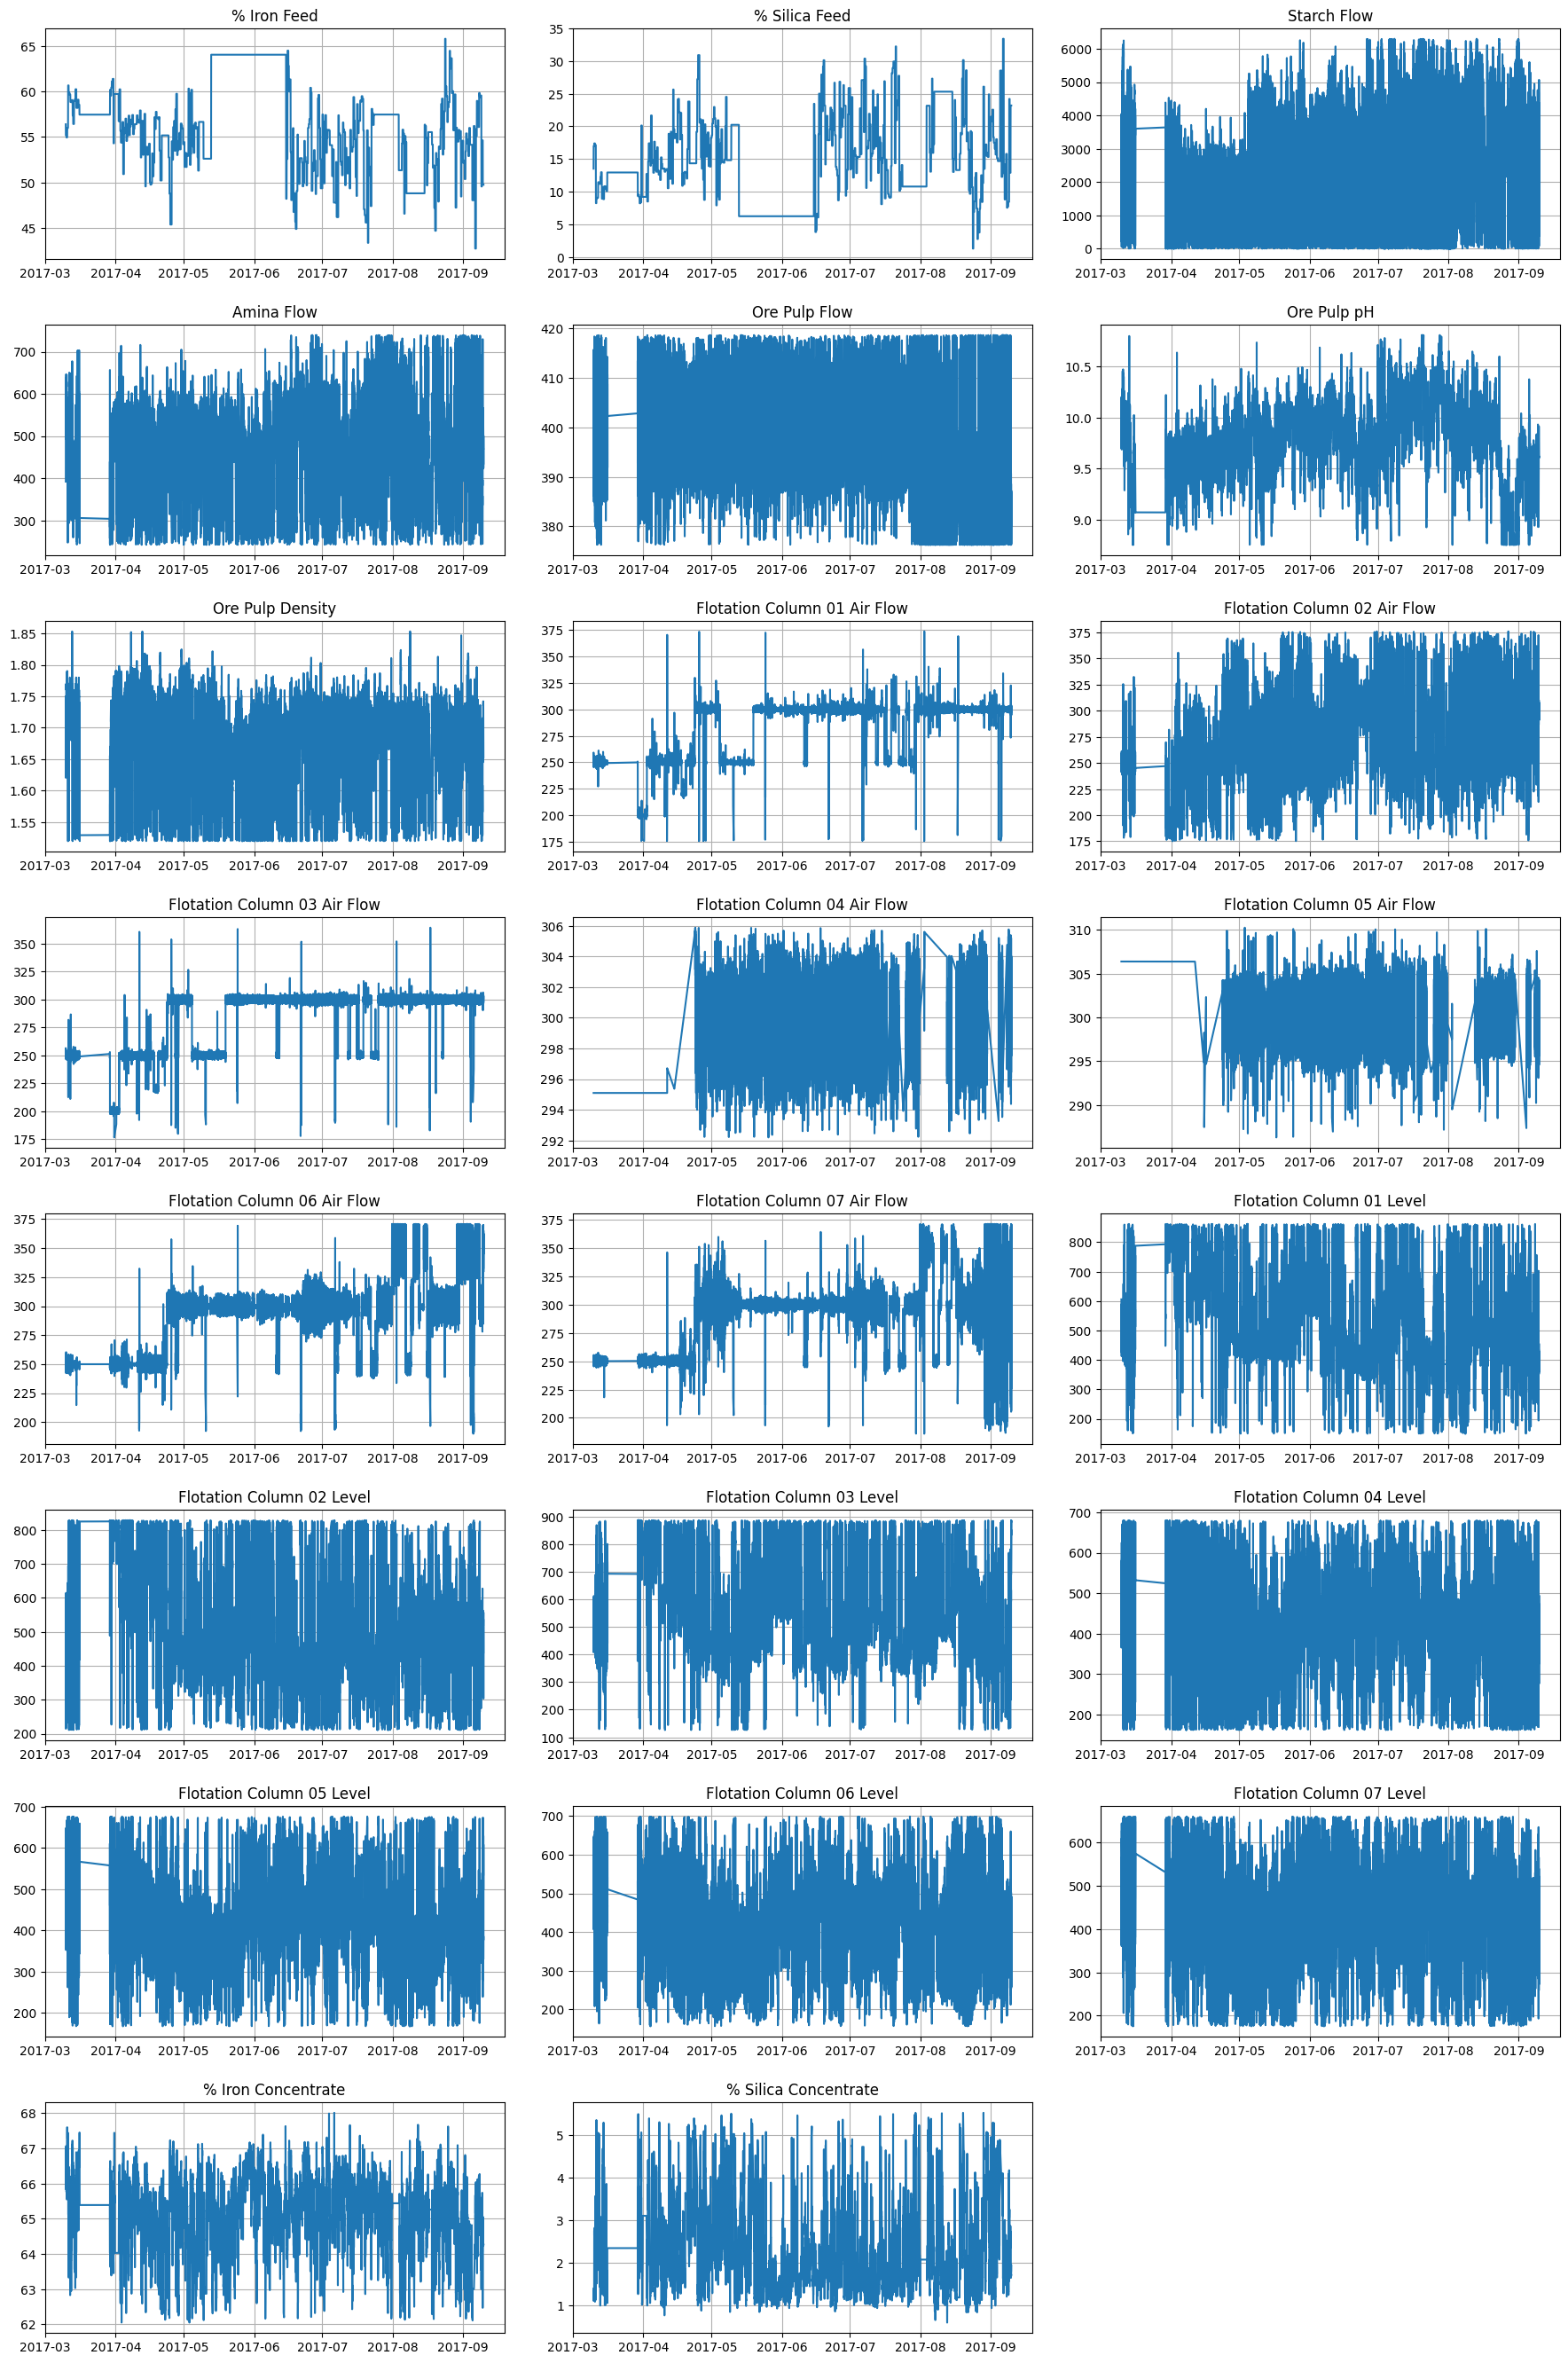

In [24]:
# Plot all in one figure

# Get numeric variables
numeric_variables = df.select_dtypes(include='number')

# Subplots per row for better visualization
subplots_per_row = 3
num_variables = len(numeric_variables.columns)
num_rows = (num_variables + subplots_per_row - 1) // subplots_per_row

fig, axes = plt.subplots(nrows=num_rows, ncols=subplots_per_row, figsize=(18, 27), sharex=False)

axes = axes.flatten()

# Plot time series for each numeric variable
for i, col in enumerate(numeric_variables.columns):
    ax = axes[i]
    ax.plot(df.index, df[col])
    ax.set_title(col)
    ax.grid(True)

for i in range(num_variables, num_rows * subplots_per_row):
    fig.delaxes(axes[i])

plt.tight_layout(pad=2.0)
plt.show()

- Plot the time series for the variables in multiple figures
- Plot the time series for just one variable

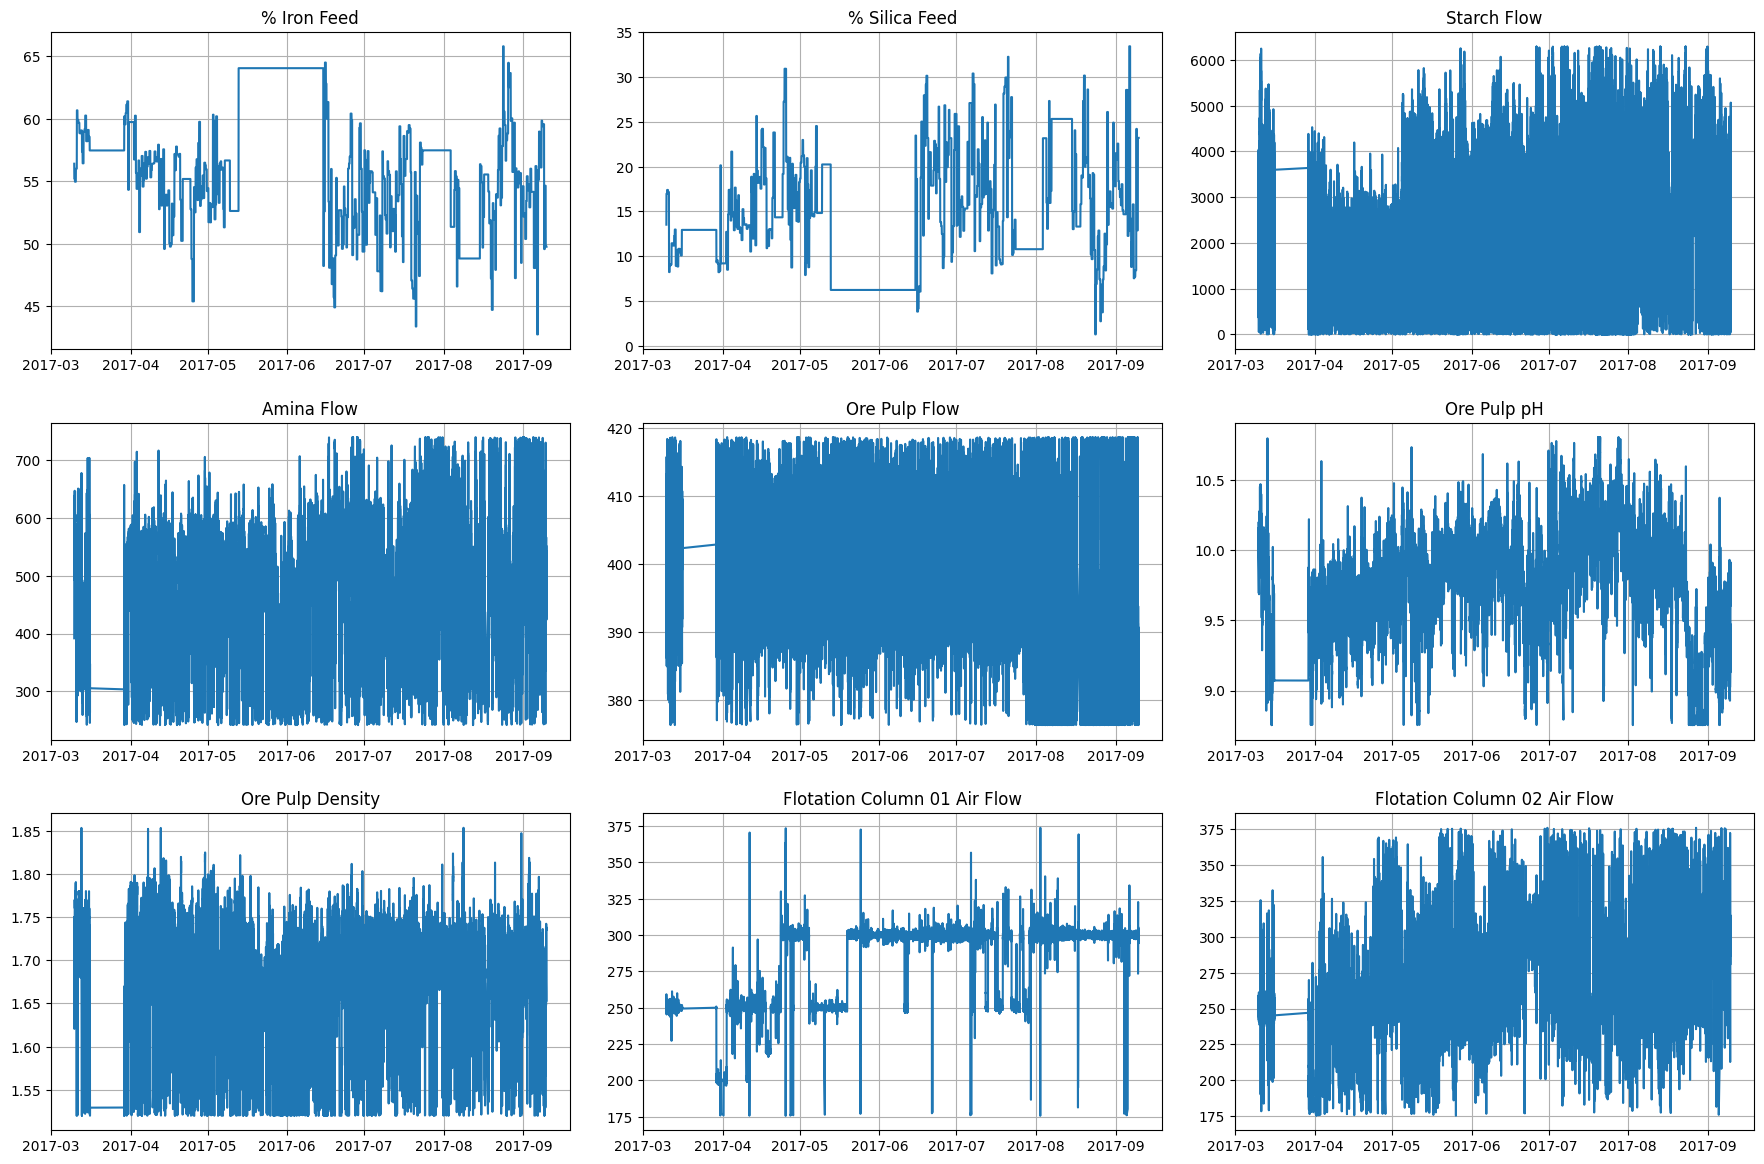

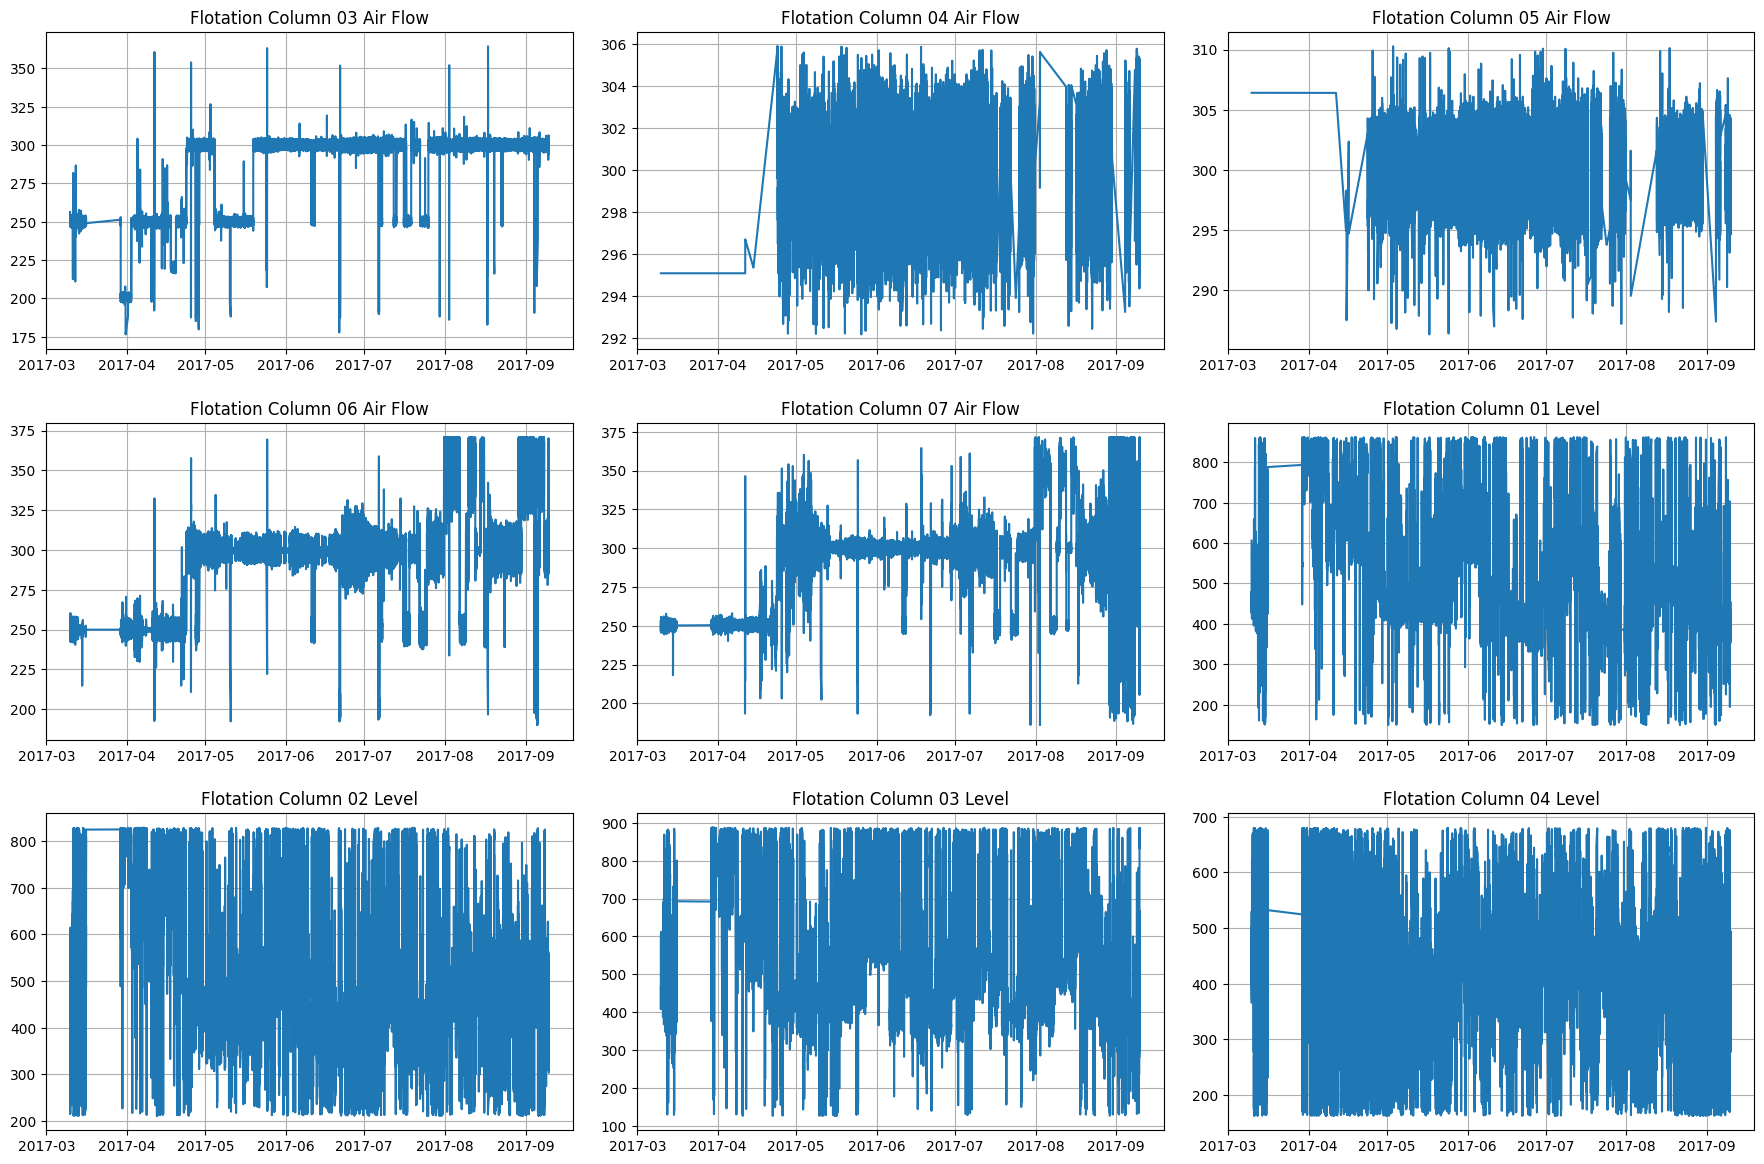

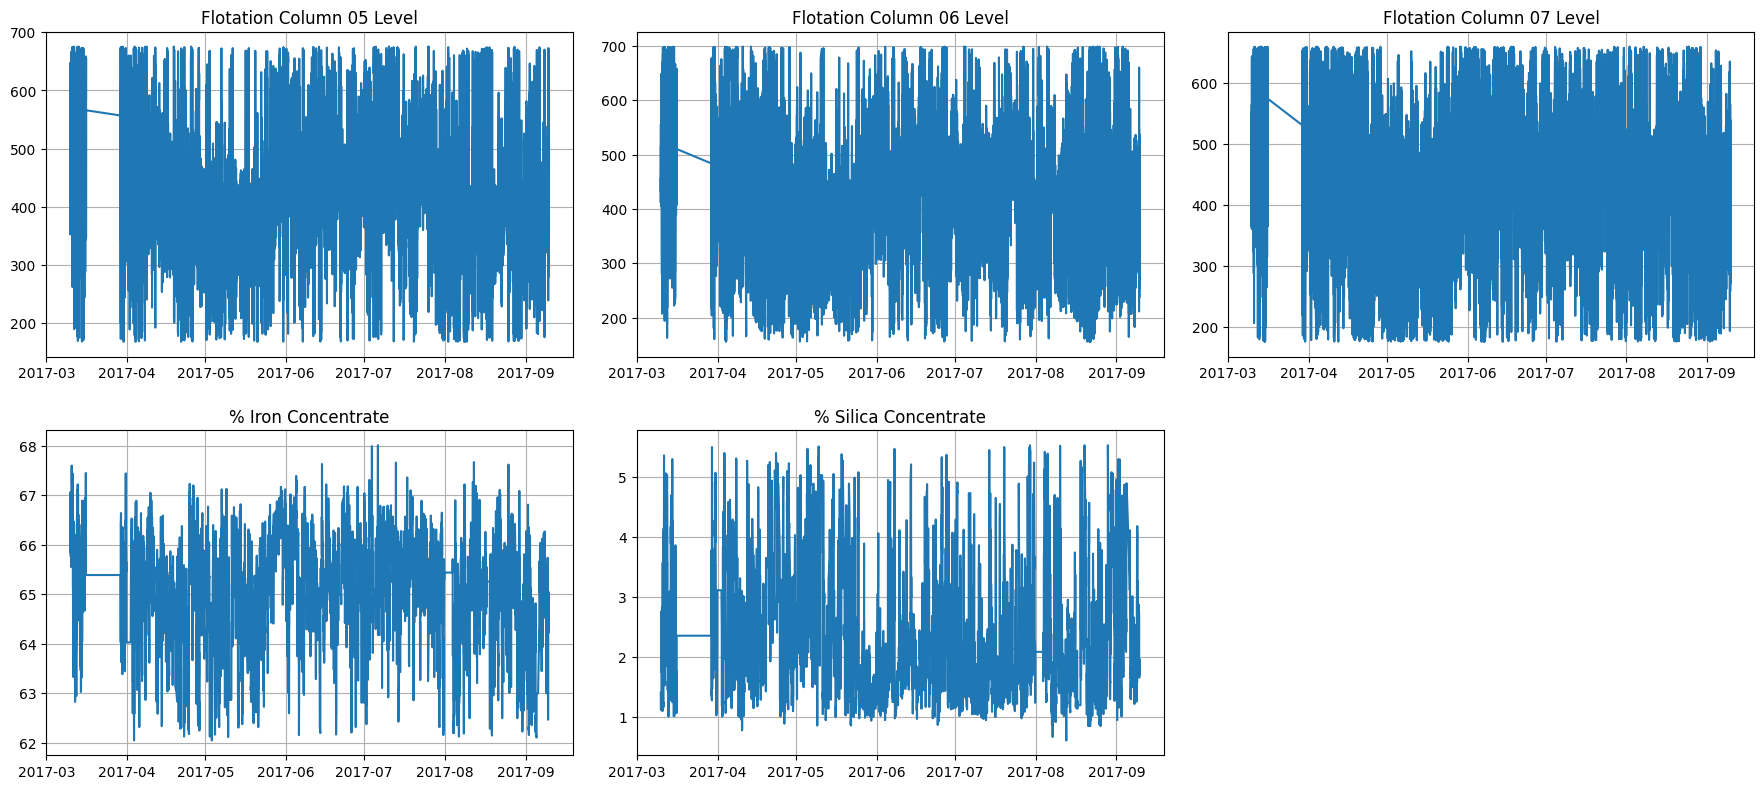

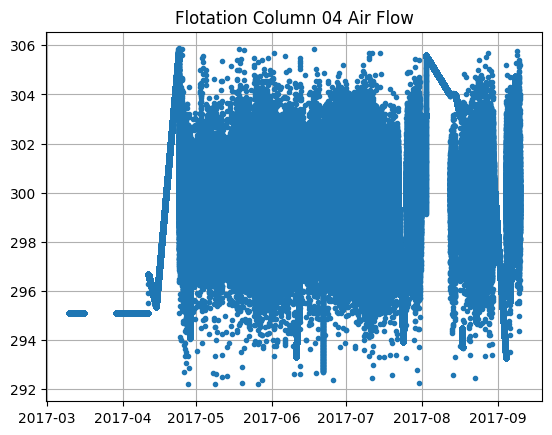

In [25]:
# Plot in multiple figures

# Get numeric variables
numeric_variables = df.select_dtypes(include='number')

# Subplots per row for better visualization
subplots_per_row = 3
num_variables = len(numeric_variables.columns)
num_rows = 3
col = numeric_variables.columns

# Plot the time series for all numeric variables
variables_plotted = 0
for fig_index in range(round(num_variables/(num_rows*subplots_per_row))):
    # Make num_rows*subplots_per_row plots
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=subplots_per_row, figsize=(18,12))
    axes = axes.flatten()
    
    if variables_plotted + num_rows*subplots_per_row > len(numeric_variables.columns):
        upper_bound = len(numeric_variables.columns)
    else:
        upper_bound = variables_plotted + num_rows*subplots_per_row
        
    variables_plotted_before = variables_plotted
    for i in range(variables_plotted,upper_bound):
        ax = axes[i-variables_plotted_before]
        ax.plot(df.index, df[col[i]])
        ax.set_title(col[i])
        ax.grid(True)
        variables_plotted = variables_plotted + 1

    # Remove unnecessary axes
    if variables_plotted < variables_plotted_before + num_rows*subplots_per_row:
        for i in range(variables_plotted - variables_plotted_before, num_rows*subplots_per_row):
            fig.delaxes(axes[i])

    plt.tight_layout(pad=2.0)
    plt.show()

# Plot the time series for just one variable
# Using just marker shows better where values stay the same
column_name = 'Flotation Column 04 Air Flow'
plt.plot(df.index, df[column_name], '.')
plt.title(column_name)
plt.grid(True)
plt.show()

### Need to provde description:
- Do we need resample or preprocess the data to make it synchronize? If yes then what is the plan?
- Is there are any irrelevant or redundant variables that don't contribute to the analysis or prediction.
- Identification of pretreatment steps, and a plan on how to do data pretreatment
- Identify which variables are time series data and which are not. Time series data will have timestamps associated with them.
- I dentify different measurement unit or scale of the variables
- How do we deal with the different measurements/scale

### Identification of Pretreatment Steps:

- Handling Missing Values: If missing values are detected, decide on a strategy to handle them. Options include imputation (e.g., mean, median, forward-fill, or interpolation) or removal of rows/columns with missing values.
- Resampling: If time series data is not synchronized, we may need to resample it to a consistent time interval.
- Feature Selection: Assess the relevance of each variable for our analysis or modeling task. Remove any irrelevant or redundant variables.
- Data Scaling/Normalization: Depending on the modeling techniques that we plan to use, may need to scale or normalize the data to ensure all variables have similar ranges.
- Outlier Detection and Handling: Identify and handle outliers if they exist in the dataset. Outliers can significantly impact modeling results.
- Data Splitting: FOr our predictive models, need to decide how to split the data into training, validation, and test sets.
